<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/detectron2_pelvis16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
torch.cuda.empty_cache()

2.2.1+cu121 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0.1
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, astropy, bokeh, dask, distributed, fastai, flax, fvcore, huggingface-hub, omegaconf, orbax-checkpoint, PyDrive, PyDrive2, transformers, yacs


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.solver.build import get_default_optimizer_params
from detectron2.solver.build import maybe_add_gradient_clipping
from detectron2.engine import HookBase
import detectron2.utils.comm as comm

In [5]:
# MetadataCatalog.remove("sk_keypoints_train")
# DatasetCatalog.remove("sk_keypoints_train")
# MetadataCatalog.remove("sk_keypoints_val")
# DatasetCatalog.remove("sk_keypoints_val")

In [6]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json"
val_img_dir="/content/drive/MyDrive/Dataset/aspine202030604/images"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Validation.json"

In [7]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("sk_keypoints_train", {}, train_annotations_file, train_img_dir)
register_coco_instances("sk_keypoints_val", {}, val_annotations_file, val_img_dir)

In [8]:
keypoint_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
keypoint_flip_map = []
# keypoint_connection_rules = [('left_eye', 'left_eye', (102, 204, 255)),('nose', 'left_eye', (102, 204, 255)),('nose', 'right_eye', (102, 204, 255))]

In [9]:
from detectron2.data import MetadataCatalog

MetadataCatalog.get("sk_keypoints_train").thing_classes = ["pelvis16"]
MetadataCatalog.get("sk_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("sk_keypoints_train").evaluator_type="coco"
MetadataCatalog.get("sk_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("sk_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("sk_keypoints_val").thing_classes = ["pelvis16"]
MetadataCatalog.get("sk_keypoints_val").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("sk_keypoints_val").evaluator_type="coco"
MetadataCatalog.get("sk_keypoints_val").keypoint_names = keypoint_names
MetadataCatalog.get("sk_keypoints_val").keypoint_flip_map = keypoint_flip_map

In [10]:
sk_metadata = MetadataCatalog.get("sk_keypoints_train")

In [11]:
dataset_dicts = DatasetCatalog.get("sk_keypoints_train")
val_dataset_dicts = DatasetCatalog.get("sk_keypoints_val")

[05/15 14:14:08 d2.data.datasets.coco]: Loaded 188 images in COCO format from /content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Train.json
[05/15 14:14:08 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/drive/MyDrive/Dataset/aspine202030604/annotations/person_keypoints_Validation.json


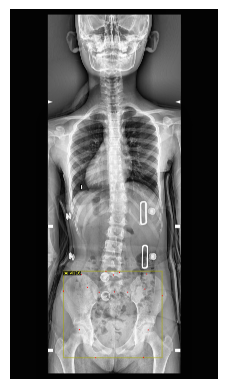

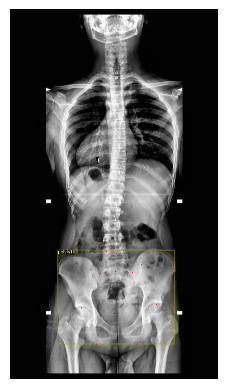

In [12]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=sk_metadata, scale=5)
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table

from detectron2.evaluation import DatasetEvaluator

try:
    from detectron2.evaluation.fast_eval_api import COCOeval_opt
except ImportError:
    COCOeval_opt = COCOeval


class COCOEvaler(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.
    The metrics range from 0 to 100 (instead of 0 to 1), where a -1 or NaN means
    the metric cannot be computed (e.g. due to no predictions made).

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        max_dets_per_image=None,
        use_fast_impl=True,
        kpt_oks_sigmas=([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]),
        allow_cached_coco=True,
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file that can be loaded with `torch.load` and
                   contains all the results in the format they are produced by the model.
                2. "coco_instances_results.json" a json file in COCO's result format.
            max_dets_per_image (int): limit on the maximum number of detections per image.
                By default in COCO, this limit is to 100, but this can be customized
                to be greater, as is needed in evaluation metrics AP fixed and AP pool
                (see https://arxiv.org/pdf/2102.01066.pdf)
                This doesn't affect keypoint evaluation.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
            allow_cached_coco (bool): Whether to use cached coco json from previous validation
                runs. You should set this to False if you need to use different validation data.
                Defaults to True.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir

        if use_fast_impl and (COCOeval_opt is COCOeval):
            self._logger.info("Fast COCO eval is not built. Falling back to official COCO eval.")
            use_fast_impl = False
        self._use_fast_impl = use_fast_impl

        # COCOeval requires the limit on the number of detections per image (maxDets) to be a list
        # with at least 3 elements. The default maxDets in COCOeval is [1, 10, 100], in which the
        # 3rd element (100) is used as the limit on the number of detections per image when
        # evaluating AP. COCOEvaluator expects an integer for max_dets_per_image, so for COCOeval,
        # we reformat max_dets_per_image into [1, 10, max_dets_per_image], based on the defaults.
        if max_dets_per_image is None:
            max_dets_per_image = [1, 10, 100]
        else:
            max_dets_per_image = [1, 10, max_dets_per_image]
        self._max_dets_per_image = max_dets_per_image

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            if output_dir is None:
                raise ValueError(
                    "output_dir must be provided to COCOEvaluator "
                    "for datasets not in COCO format."
                )
            self._logger.info(f"Trying to convert '{dataset_name}' to COCO format ...")

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path, allow_cached=allow_cached_coco)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[COCOEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            assert task in {"bbox", "segm", "keypoints"}, f"Got unknown task: {task}!"
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    cocoeval_fn=COCOeval_opt if self._use_fast_impl else COCOeval,
                    img_ids=img_ids,
                    max_dets_per_image=self._max_dets_per_image,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0**2, 1e5**2],  # all
        [0**2, 32**2],  # small
        [32**2, 96**2],  # medium
        [96**2, 1e5**2],  # large
        [96**2, 128**2],  # 96-128
        [128**2, 256**2],  # 128-256
        [256**2, 512**2],  # 256-512
        [512**2, 1e5**2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt,
    coco_results,
    iou_type,
    kpt_oks_sigmas=None,
    cocoeval_fn=COCOeval_opt,
    img_ids=None,
    max_dets_per_image=None,
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = cocoeval_fn(coco_gt, coco_dt, iou_type)
    # For COCO, the default max_dets_per_image is [1, 10, 100].
    if max_dets_per_image is None:
        max_dets_per_image = [1, 10, 100]  # Default from COCOEval
    else:
        assert (
            len(max_dets_per_image) >= 3
        ), "COCOeval requires maxDets (and max_dets_per_image) to have length at least 3"
        # In the case that user supplies a custom input for max_dets_per_image,
        # apply COCOevalMaxDets to evaluate AP with the custom input.
        if max_dets_per_image[2] != 100:
            coco_eval = COCOevalMaxDets(coco_gt, coco_dt, iou_type)
    if iou_type != "keypoints":
        coco_eval.params.maxDets = max_dets_per_image

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[COCOEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval


class COCOevalMaxDets(COCOeval):
    """
    Modified version of COCOeval for evaluating AP with a custom
    maxDets (by default for COCO, maxDets is 100)
    """

    def summarize(self):
        """
        Compute and display summary metrics for evaluation results given
        a custom value for  max_dets_per_image
        """

        def _summarize(ap=1, iouThr=None, areaRng="all", maxDets=100):
            p = self.params
            iStr = " {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}"
            titleStr = "Average Precision" if ap == 1 else "Average Recall"
            typeStr = "(AP)" if ap == 1 else "(AR)"
            iouStr = (
                "{:0.2f}:{:0.2f}".format(p.iouThrs[0], p.iouThrs[-1])
                if iouThr is None
                else "{:0.2f}".format(iouThr)
            )

            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = self.eval["precision"]
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:, :, :, aind, mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = self.eval["recall"]
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:, :, aind, mind]
            if len(s[s > -1]) == 0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s > -1])
            print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
            return mean_s

        def _summarizeDets():
            stats = np.zeros((12,))
            # Evaluate AP using the custom limit on maximum detections per image
            stats[0] = _summarize(1, maxDets=self.params.maxDets[2])
            stats[1] = _summarize(1, iouThr=0.5, maxDets=self.params.maxDets[2])
            stats[2] = _summarize(1, iouThr=0.75, maxDets=self.params.maxDets[2])
            stats[3] = _summarize(1, areaRng="small", maxDets=self.params.maxDets[2])
            stats[4] = _summarize(1, areaRng="medium", maxDets=self.params.maxDets[2])
            stats[5] = _summarize(1, areaRng="large", maxDets=self.params.maxDets[2])
            stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
            stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
            stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
            stats[9] = _summarize(0, areaRng="small", maxDets=self.params.maxDets[2])
            stats[10] = _summarize(0, areaRng="medium", maxDets=self.params.maxDets[2])
            stats[11] = _summarize(0, areaRng="large", maxDets=self.params.maxDets[2])
            return stats

        def _summarizeKps():
            stats = np.zeros((10,))
            stats[0] = _summarize(1, maxDets=20)
            stats[1] = _summarize(1, maxDets=20, iouThr=0.5)
            stats[2] = _summarize(1, maxDets=20, iouThr=0.75)
            stats[3] = _summarize(1, maxDets=20, areaRng="medium")
            stats[4] = _summarize(1, maxDets=20, areaRng="large")
            stats[5] = _summarize(0, maxDets=20)
            stats[6] = _summarize(0, maxDets=20, iouThr=0.5)
            stats[7] = _summarize(0, maxDets=20, iouThr=0.75)
            stats[8] = _summarize(0, maxDets=20, areaRng="medium")
            stats[9] = _summarize(0, maxDets=20, areaRng="large")
            return stats

        if not self.eval:
            raise Exception("Please run accumulate() first")
        iouType = self.params.iouType
        if iouType == "segm" or iouType == "bbox":
            summarize = _summarizeDets
        elif iouType == "keypoints":
            summarize = _summarizeKps
        self.stats = summarize()

    def __str__(self):
        self.summarize()

In [14]:
class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaler(dataset_name, cfg, False, output_folder)


    @classmethod
    def build_train_loader(cls, cfg):                #train loader for data augmentation
      return build_detection_train_loader(cfg,
        mapper=DatasetMapper(cfg, is_train=True, augmentations=[
            T.RandomBrightness(0.9,1.1),
            T.RandomContrast(0.9, 1.1)
        ]))

    # def build_train_loader(cls, cfg):
    #     mapper = DatasetMapper(cfg, is_train=True, augmentations=[])
    #     return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Build an optimizer from config.
        """
        params = get_default_optimizer_params(model)
        return maybe_add_gradient_clipping(cfg, torch.optim.AdamW)(
                          params,
                          lr=cfg.SOLVER.BASE_LR,
                          weight_decay=cfg.SOLVER.WEIGHT_DECAY)

class ValidationLoss(HookBase):
    def __init__(self, cfg, DATASETS_VAL_NAME):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = DATASETS_VAL_NAME##
        self._loader = iter(build_detection_train_loader(self.cfg))

    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)

            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced,
                                  **loss_dict_reduced)

In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"
# cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file("/content/drive/MyDrive/Colab Notebooks/model_cfg.yaml")
cfg.DATASETS.TRAIN = ("sk_keypoints_train",)
cfg.DATASETS.TEST = ("sk_keypoints_val",)
cfg.OUTPUT_DIR = '/content/drive/MyDrive/Dataset/output'
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/output/model_final.pth'
cfg.DATASETS.VAL = ("sk_keypoints_val",)


cfg.DATALOADER.NUM_WORKERS = 8
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 8e-5  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   #128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

cfg.TEST.EVAL_PERIOD = 100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
val_loss = ValidationLoss(cfg, cfg.DATASETS.VAL)  ##多加的参数
trainer.register_hooks([val_loss])
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

[05/15 14:14:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
trainer.resume_or_load(resume=True)
trainer.train()

[05/15 14:14:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Dataset/output/model_final.pth ...
[05/15 14:14:31 d2.engine.hooks]: Loading scheduler from state_dict ...
[05/15 14:14:31 d2.engine.train_loop]: Starting training from iteration 100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  keypoints = tor

[05/15 14:15:18 d2.utils.events]:  eta: 0:57:43  iter: 119  total_loss: 4.702  loss_cls: 0.07577  loss_box_reg: 0.06104  loss_keypoint: 4.46  loss_rpn_cls: 0.065  loss_rpn_loc: 0.004179  total_val_loss: 8.073  val_loss_cls: 0.08703  val_loss_box_reg: 0.06663  val_loss_keypoint: 7.623  val_loss_rpn_cls: 0.1977  val_loss_rpn_loc: 0.05737    time: 1.8415  last_time: 1.8454  data_time: 0.0389  last_data_time: 0.0116   lr: 9.5905e-06  max_mem: 17385M


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Dataset/output

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Colab Notebooks/model_cfg.yaml")
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Dataset/output/model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 16

predictor = DefaultPredictor(cfg)

In [ ]:
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
# v = Visualizer(im[:, :, ::-1],metadata=sk_metadata,scale=5,
# )

# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.figure(figsize = (14, 10))
# plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
# plt.show()

for d in random.sample(val_dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1],metadata=sk_metadata,scale=5,
  )
  outputs = predictor(img)
  visualizer = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize = (14, 10))
  plt.imshow(cv2.cvtColor(visualizer.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
  plt.show()

# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj